In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from scikeras.wrappers import KerasClassifier
from keras_tuner import RandomSearch
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



2024-07-04 15:32:48.261000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 15:32:48.261272: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 15:32:48.263452: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 15:32:48.294575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 15:32:49.174042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
def load_dataset(file_path):
    with h5py.File(file_path, 'r') as file:
        obj_ref = file['CENet'][0, 0]
        obj = file[obj_ref]

        X_cc = obj['X_cc'][:]
        Y_cc = obj['Y_cc'][:]

    return X_cc, Y_cc

In [20]:
def build_model(hp):
    kernel_size = hp.Choice('kernel_size', ['2,2', '4,4', '8,8', '16,16'])
    kernel_size = tuple(map(int, kernel_size.split(',')))
    
    num_filters = hp.Choice('num_filters', [64,128,256])

    input_tensor = Input(shape=(2, 64, 64))
    network = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=2, padding='same')(input_tensor)
    network = MaxPooling2D((1,1))(network)
    network = BatchNormalization()(network)
    network = ReLU()(network)
    network = GlobalAveragePooling2D()(network)
    output_tensor = Dense(8192, activation='linear')(network)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=Adam(learning_rate=0.05), loss='mean_squared_error')
    return model

In [3]:
file_path = 'training_data2.mat'

X_cc, Y_cc = load_dataset(file_path)

print('X_cc shape:', X_cc.shape)
print('Y_cc shape:', Y_cc.shape)

X_cc shape: (12000, 2, 64, 64)
Y_cc shape: (8192, 12000)


In [4]:
Y_cc = Y_cc.T

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_cc, Y_cc, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=12,
    executions_per_trial=1,
    directory='output',
    project_name='Trabalho'
)

2024-07-01 21:01:01.841564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 21:01:01.841914: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:", best_hyperparameters.values)

Trial 12 Complete [00h 00m 15s]
val_loss: 0.36738964915275574

Best val_loss So Far: 0.29972749948501587
Total elapsed time: 00h 07m 15s
Best hyperparameters: {'kernel_size': '8,8', 'num_filters': 128}


/home/cesar/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
def residual_block(x, filters, kernel_size=8, stride=2):

    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [7]:
input_tensor = Input(shape=(2, 64, 64))

In [8]:
x = Conv2D(128, kernel_size=8, strides=2, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)

2024-07-04 15:33:21.408400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 15:33:21.409098: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128, stride=2)

In [10]:
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(8192, activation='linear')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer=Adam(learning_rate=0.002), loss='mean_squared_error')

In [11]:
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.003)

In [12]:
epochs = 15
batch_size = 32

history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 6.7880 - val_loss: 2.9262
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - loss: 1.6600 - val_loss: 0.6282
Epoch 3/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - loss: 0.4635 - val_loss: 0.3181
Epoch 4/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - loss: 0.2937 - val_loss: 0.2227
Epoch 5/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - loss: 0.1942 - val_loss: 0.1491
Epoch 6/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - loss: 0.1631 - val_loss: 0.1619
Epoch 7/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - loss: 0.1674 - val_loss: 0.1320
Epoch 8/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - loss: 0.1104 - val_loss: 0.0739
Epoch 9/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 262ms/step - loss: 0.0806 - val_loss: 0.0963
Epoch 10/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - loss: 0.0606 - val_loss: 0.0257
Epoch 11/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 261ms/step - loss: 0.0343 - val_loss: 0.0386
Epoch 12/15
210/210

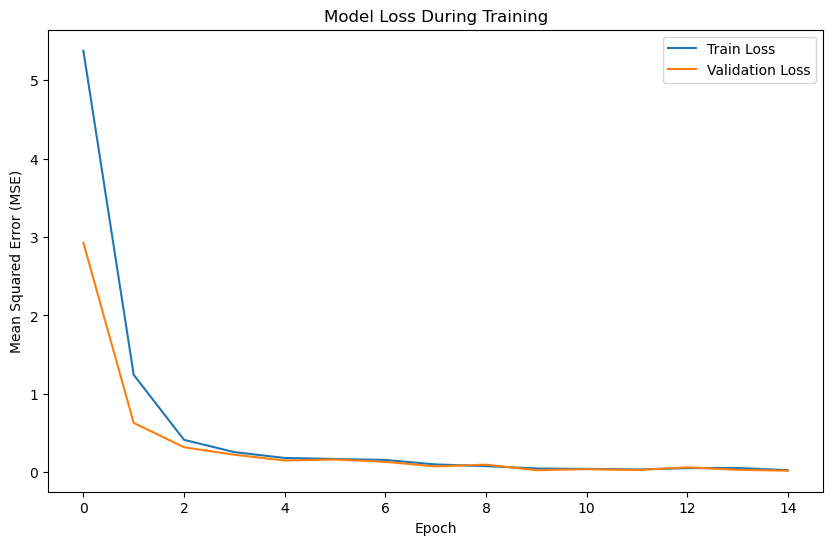

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [14]:
model = load_model('best_model.keras')

In [15]:
y_pred = model.predict(X_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [16]:
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

In [17]:
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

Mean Squared Error (MSE): 0.01834087220145693
Mean Absolute Error (MAE): 0.09935347984298563
R-squared (R²): 0.9976429831058465
